Within this notebook, there is a basic exploratory data analysis and a comparison of classification models in predicting stroke in patients.
Feedback, criticism and comments are much appreciated.

Attribute Info:
1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# data prep
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# under/over sampling
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# modelling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import RandomizedSearchCV

# classification metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

In [4]:
df.drop(['id'], inplace=True, axis=1)

In [5]:
df[df['smoking_status'] == 'Unknown'].smoking_status.count()

1544

Since 'Unknown' smoking status is a large portion of the data, we will not drop it.

In [6]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


The minimum age is 0.08. Lets investigate this

In [7]:
df[df['age'] < 1].head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
363,Female,0.64,0,0,No,children,Urban,83.82,24.9,Unknown,0
376,Female,0.88,0,0,No,children,Rural,88.11,15.5,Unknown,0
564,Female,0.32,0,0,No,children,Rural,73.71,16.2,Unknown,0
982,Male,0.88,0,0,No,children,Rural,157.57,19.2,Unknown,0
996,Male,0.24,0,0,No,children,Rural,118.87,16.3,Unknown,0


Are these patients truly younger than 1 year when this data was recorded? I don't know too much about how the data was collected and if these are misinputs, but these values could be true because their work type is 'children'

# Exploratory Data Analysis

# Target Variable

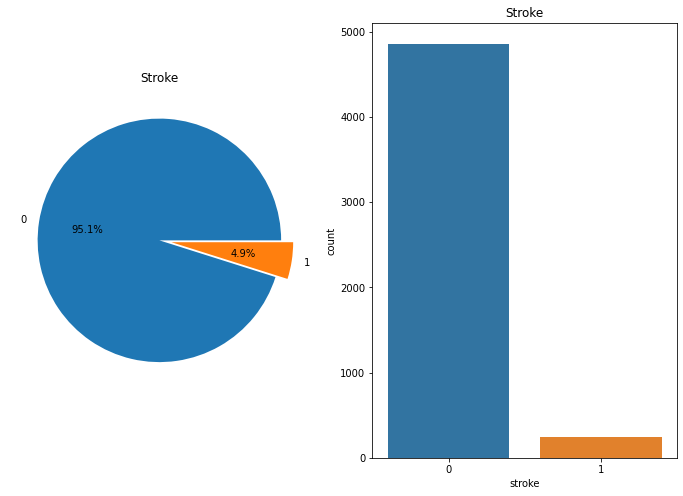

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12,8))

df['stroke'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%', ax=ax[0])
sns.countplot(x='stroke', data=df, ax=ax[1])

ax[0].set_ylabel('')
ax[0].set_title('Stroke')
ax[1].set_title('Stroke')

plt.show()

Note that we are dealing with an imbalanced data set. About 5:95 or 1:19 ratio

# Correlation

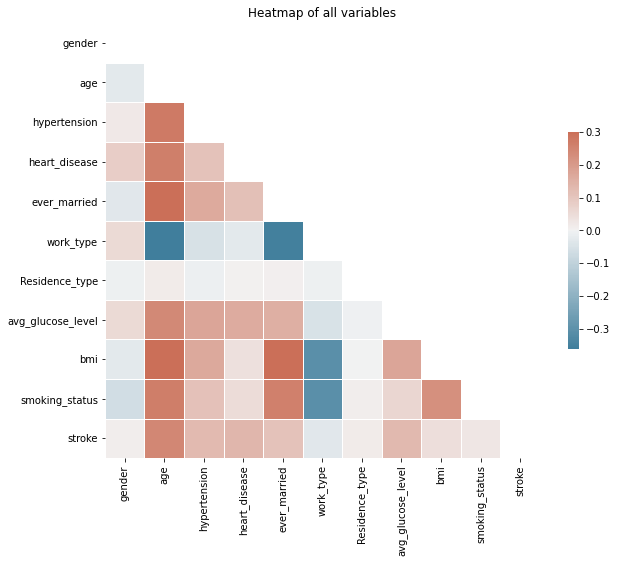

In [9]:
# convert discrete variables with string values to numeric as label encoding
dfcorr = df.copy()
dfcorr[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']] = dfcorr[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']].astype('category')
dfcorr['gender'] = dfcorr['gender'].cat.codes
dfcorr['ever_married'] = dfcorr['ever_married'].cat.codes
dfcorr['work_type'] = dfcorr['work_type'].cat.codes
dfcorr['Residence_type'] = dfcorr['Residence_type'].cat.codes
dfcorr['smoking_status'] = dfcorr['smoking_status'].cat.codes

corr = dfcorr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(10,8))

cmap= sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink":.5})

plt.title('Heatmap of all variables')

plt.show()

The lifestyle variables, residence_type, work_type and smoking_status don't correlate well with stroke. However, smoking_status has a lot of unknown values. Smoking_status will be investigated further in the notebook.

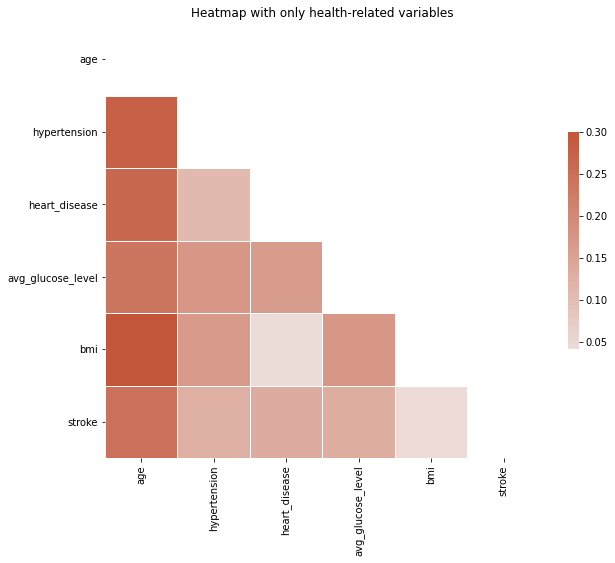

In [10]:
corr2 = df.corr()
mask = np.triu(np.ones_like(corr2, dtype=bool))

fig, ax = plt.subplots(figsize=(10,8))

cmap= sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink":.5})

plt.title('Heatmap with only health-related variables')

plt.show()

seems like age is correlated with everything

# Gender

In [11]:
df[['gender','stroke']].groupby(['gender']).count()

,stroke
gender,
Female,2994
Male,2115
Other,1


lets remove 'Other' since there is only 1 entry

In [12]:
df = df[df['gender'] != 'Other']

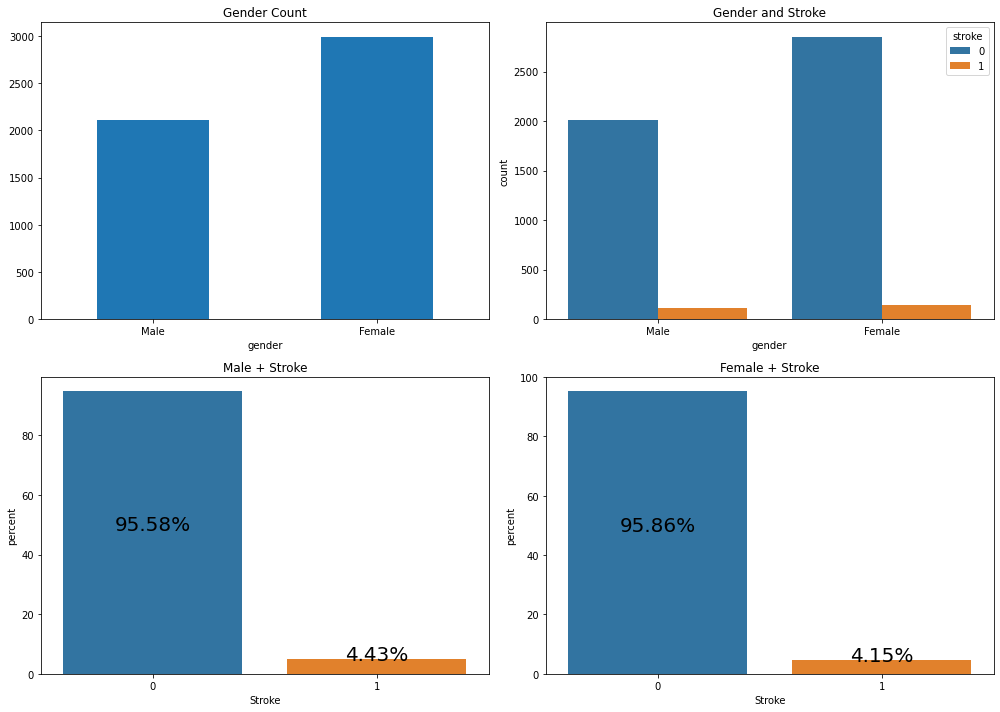

In [13]:
# male
dfmale = df[df['gender'] == 'Male']
dfmale = dfmale['stroke'].value_counts(normalize=True)
dfmale = dfmale.mul(100)
dfmale = dfmale.rename('percent').reset_index()

# female
dffemale = df[df['gender'] == 'Female']
dffemale = dffemale['stroke'].value_counts(normalize=True)
dffemale = dffemale.mul(100)
dffemale = dffemale.rename('percent').reset_index()



fig, ax = plt.subplots(2, 2, figsize=(14,10))

df[['gender','stroke']].groupby(['gender']).count().plot.bar(ax=ax[0,0])
sns.countplot(x='gender', hue='stroke', data=df, ax=ax[0,1])
sns.barplot(x='index', y='percent', data=dfmale, ax=ax[1,0])
sns.barplot(x='index', y='percent', data=dffemale, ax=ax[1,1])

ax[0,0].set_title('Gender Count')
ax[0,1].set_title('Gender and Stroke')
ax[1,0].set_title('Male + Stroke')
ax[1,1].set_title('Female + Stroke')

ax[1,0].set_xlabel('Stroke')
ax[1,1].set_xlabel('Stroke')

ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), rotation=0) # labels were vertical
ax[0,0].invert_xaxis() # male and female labels in wrong order
ax[0,0].get_legend().remove()

ax[1,0].text(0, 50, "95.58%", va='center', ha='center', fontsize=20)
ax[1,0].text(1, 4.7, "4.43%", ha='center', fontsize=20)

ax[1,1].text(0, 50, "95.86%", va='center', ha='center', fontsize=20)
ax[1,1].text(1, 4.3, "4.15%", ha='center', fontsize=20)

fig.tight_layout()
plt.show()

Even though there are more females than males recorded in the data, the relative % of males and females having experienced a stroke is roughly equal.

# Age

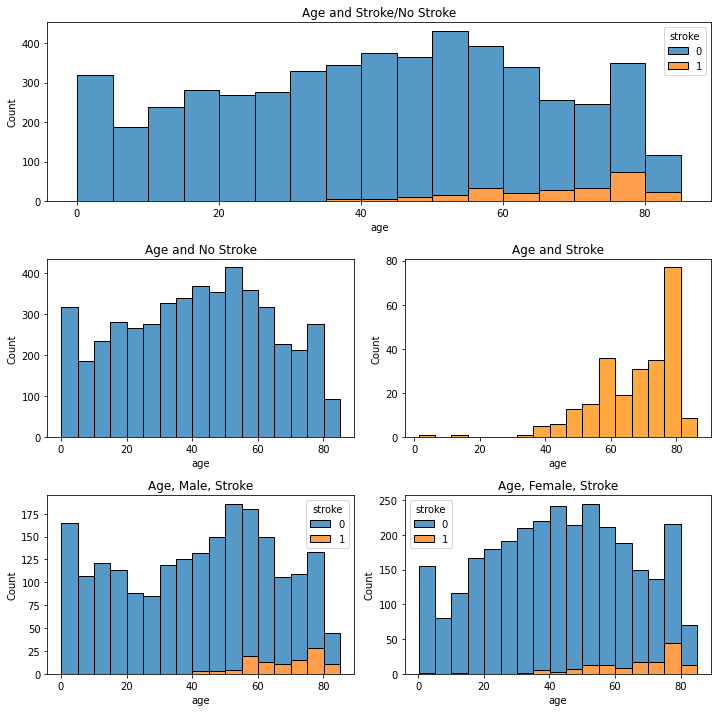

In [14]:
fig = plt.figure(figsize=(20,10))

ax = [None for _ in range(5)] # List to save ax for setting parameter

ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 1)
ax[2] = plt.subplot2grid((3,4), (1,1), colspan = 1)
ax[3] = plt.subplot2grid((3,4), (2,0), colspan = 1)
ax[4] = plt.subplot2grid((3,4), (2,1), colspan = 1)

sns.histplot(x='age', hue='stroke', multiple='stack', binwidth=5, data=df, ax=ax[0])
sns.histplot(x='age', binwidth=5, data=df[df['stroke'] == 0], ax=ax[1])
sns.histplot(x='age', color= '#FF8C00', binwidth=5, data=df[df['stroke'] == 1], ax=ax[2])
sns.histplot(x='age', hue='stroke', multiple='stack', binwidth=5, data=df[df['gender'] == 'Male'], ax=ax[3])
sns.histplot(x='age', hue='stroke', multiple='stack', binwidth=5, data=df[df['gender'] == 'Female'], ax=ax[4])

ax[0].set_title('Age and Stroke/No Stroke')
ax[1].set_title('Age and No Stroke')
ax[2].set_title('Age and Stroke')
ax[3].set_title('Age, Male, Stroke')
ax[4].set_title('Age, Female, Stroke')

fig.tight_layout()
plt.show()

This data suggests that the older the patient is, the more likely that they will have a stroke. There are a few cases where a patient had a stroke before the age of 20.

In [15]:
df[(df['age'] < 20) & (df['stroke'] == 1)]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
245,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1


Now a child at the age of about 1 and 14 having a stroke is surprising. Not sure whether this is a misinput or not. Maybe the stroke was due to a rare disease/condition? This makes me question what was considered a stroke when this data was collected, but this is out of our scope for now.

# Hypertension

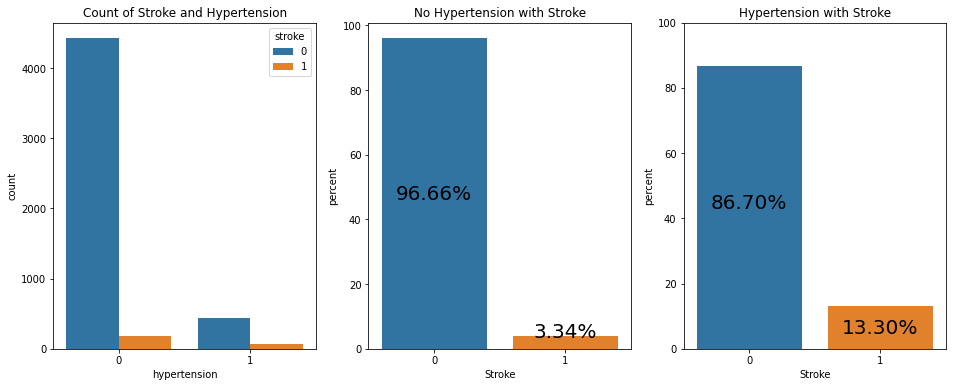

In [16]:
# no hypertension
dfnohyper = df[df['hypertension'] !=1]
dfnohyper = dfnohyper['stroke'].value_counts(normalize=True)
dfnohyper = dfnohyper.mul(100)
dfnohyper = dfnohyper.rename('percent').reset_index()

# with hypertension
dfhyper = df[df['hypertension'] !=0]
dfhyper = dfhyper['stroke'].value_counts(normalize=True)
dfhyper = dfhyper.mul(100)
dfhyper = dfhyper.rename('percent').reset_index()

fig, ax = plt.subplots(1,3, figsize=(16,6))

sns.countplot(x='hypertension', hue='stroke', data=df, ax=ax[0])
sns.barplot(x='index', y='percent', data=dfnohyper, ax=ax[1])
sns.barplot(x='index', y='percent', data=dfhyper, ax=ax[2])

ax[2].set(ylim=(0, 100))

ax[0].set_title('Count of Stroke and Hypertension')
ax[1].set_title('No Hypertension with Stroke')
ax[2].set_title('Hypertension with Stroke')

ax[1].set_xlabel('Stroke')
ax[2].set_xlabel('Stroke')

ax[1].text(0, 48, "96.66%", va='center', ha='center', fontsize=20)
ax[1].text(1, 3.5, "3.34%", ha='center', fontsize=20)
ax[2].text(0, 43, "86.70%", ha='center', fontsize=20)
ax[2].text(1, 4.7, "13.30%", ha='center', fontsize=20)

plt.show()

patients with hypertension have a higher occurrance of stroke

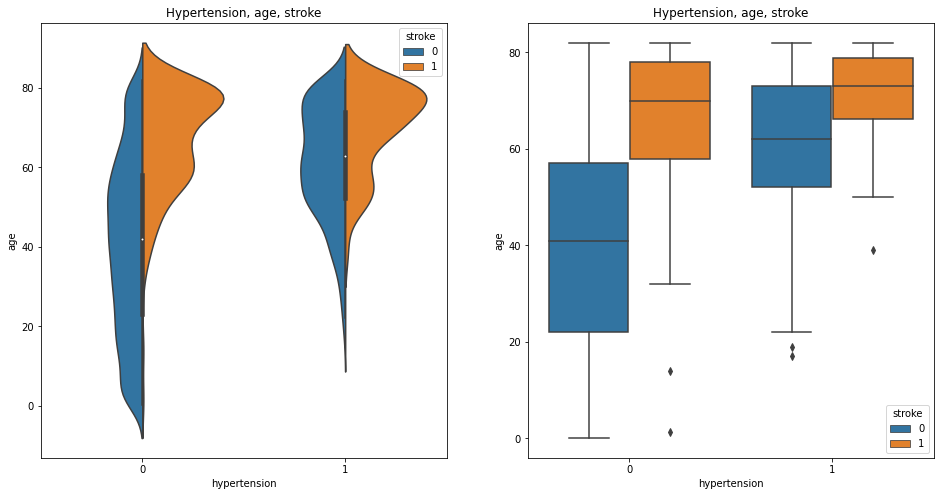

In [17]:
fig, ax= plt.subplots(1, 2, figsize=(16,8))

sns.violinplot(x='hypertension', y='age', hue='stroke', data=df, split=True, ax=ax[0])
sns.boxplot(x='hypertension', y='age', hue='stroke', data=df, ax=ax[1])

ax[0].set_title('Hypertension, age, stroke')
ax[1].set_title('Hypertension, age, stroke')

plt.show()

the larger distribution of having hypertension is located at older ages

# Heart Disease

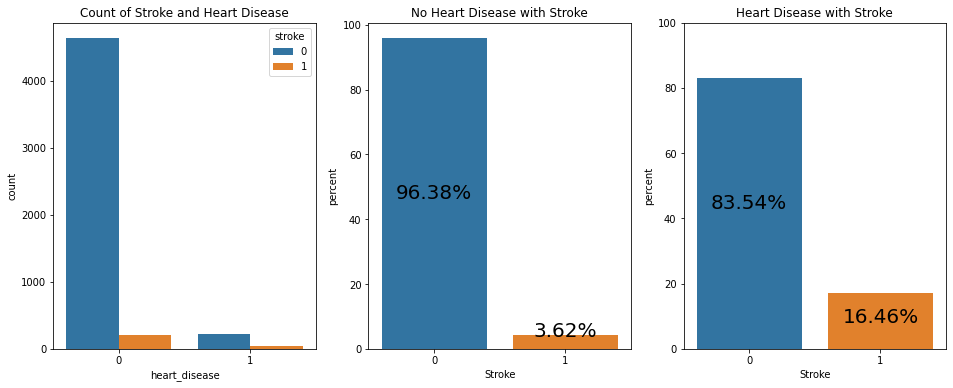

In [18]:
# no heart disease
dfnohd = df[df['heart_disease'] !=1]
dfnohd = dfnohd['stroke'].value_counts(normalize=True)
dfnohd = dfnohd.mul(100)
dfnohd = dfnohd.rename('percent').reset_index()

# with heart disease
dfhd = df[df['heart_disease'] !=0]
dfhd = dfhd['stroke'].value_counts(normalize=True)
dfhd = dfhd.mul(100)
dfhd = dfhd.rename('percent').reset_index()

fig, ax = plt.subplots(1,3, figsize=(16,6))

sns.countplot(x='heart_disease', hue='stroke', data=df, ax=ax[0])
sns.barplot(x='index', y='percent', data=dfnohd, ax=ax[1])
sns.barplot(x='index', y='percent', data=dfhd, ax=ax[2])

ax[2].set(ylim=(0, 100))

ax[0].set_title('Count of Stroke and Heart Disease')
ax[1].set_title('No Heart Disease with Stroke')
ax[2].set_title('Heart Disease with Stroke')

ax[1].set_xlabel('Stroke')
ax[2].set_xlabel('Stroke')

ax[1].text(0, 48, "96.38%", va='center', ha='center', fontsize=20)
ax[1].text(1, 3.9, "3.62%", ha='center', fontsize=20)
ax[2].text(0, 43, "83.54%", ha='center', fontsize=20)
ax[2].text(1, 8, "16.46%", ha='center', fontsize=20)

plt.show()

Although the count of patients with heart disease is very low, there is relatively a 12.84% increased occurance of strokes with patients that have a heart disease

# Average Glucose Level

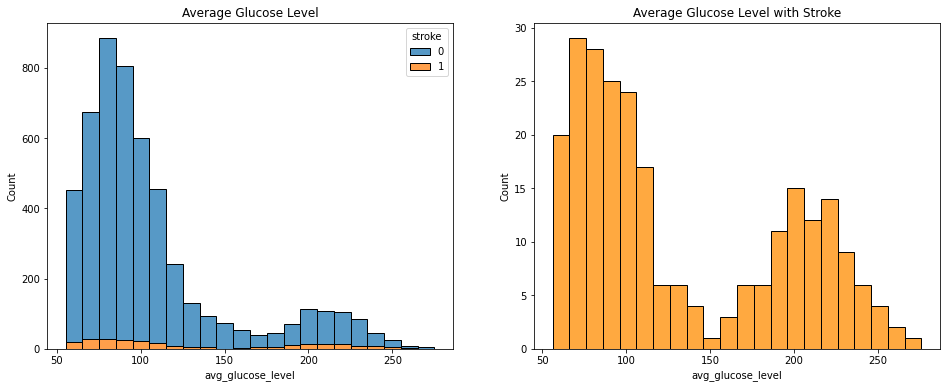

In [19]:
fig, ax = plt.subplots(1,2, figsize=(16, 6))

sns.histplot(x='avg_glucose_level', hue='stroke', multiple='stack', data=df, binwidth=10, ax=ax[0])
sns.histplot(x='avg_glucose_level', color= '#FF8C00', binwidth=10, data=df[df['stroke'] == 1], ax=ax[1])

ax[0].set_title('Average Glucose Level')
ax[1].set_title('Average Glucose Level with Stroke')
plt.show()

The shape of the second peak (avg_glucose_level above 150) for patients with stroke looks relatively higher than the second peak of the left plot, suggesting that there is a higher occurance of stroke in patients with a higher average glucose level 

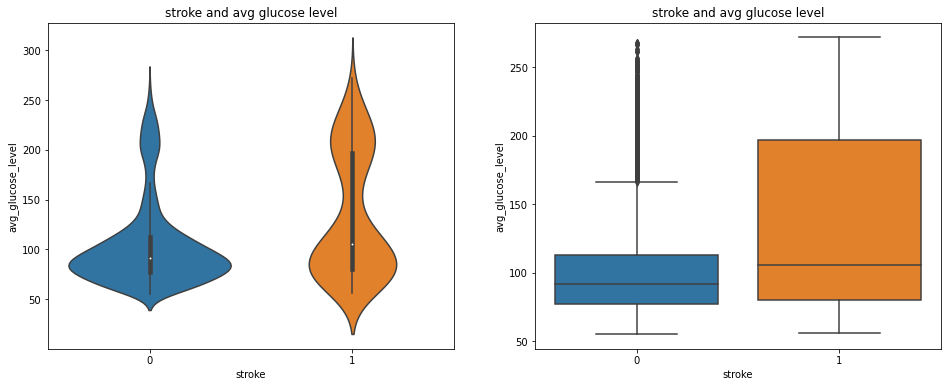

In [20]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

sns.violinplot(x='stroke', y='avg_glucose_level', data=df, ax=ax[0])
sns.boxplot(x='stroke', y='avg_glucose_level', data=df, ax=ax[1])

ax[0].set_title('stroke and avg glucose level')
ax[1].set_title('stroke and avg glucose level')


plt.show()

This plot better describes that with higher avg_glucose level, the higher risk of having a stroke. We can see more clearly than the histogram that there is a portionally larger distribution of patients with a higher average glucose level having experienced a stroke.

# BMI

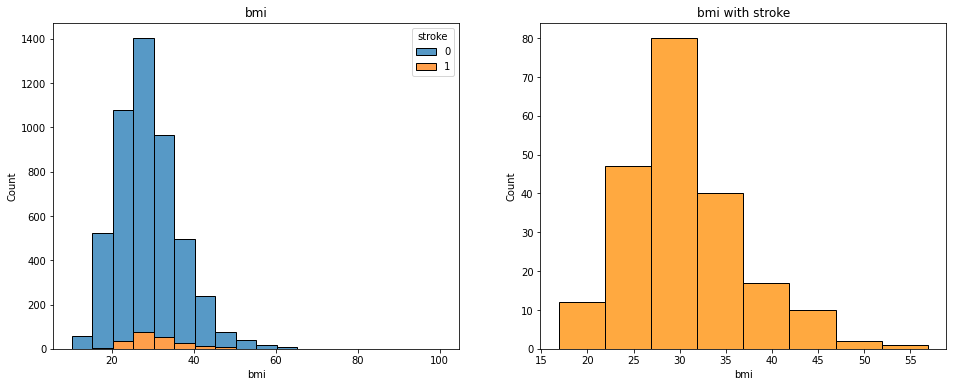

In [21]:
fig, ax = plt.subplots(1,2, figsize=(16, 6))

sns.histplot(x='bmi', hue='stroke', multiple='stack', data=df, binwidth=5, ax=ax[0])
sns.histplot(x='bmi', color= '#FF8C00', binwidth=5, data=df[df['stroke'] == 1], ax=ax[1])

ax[0].set_title('bmi')
ax[1].set_title('bmi with stroke')
plt.show()

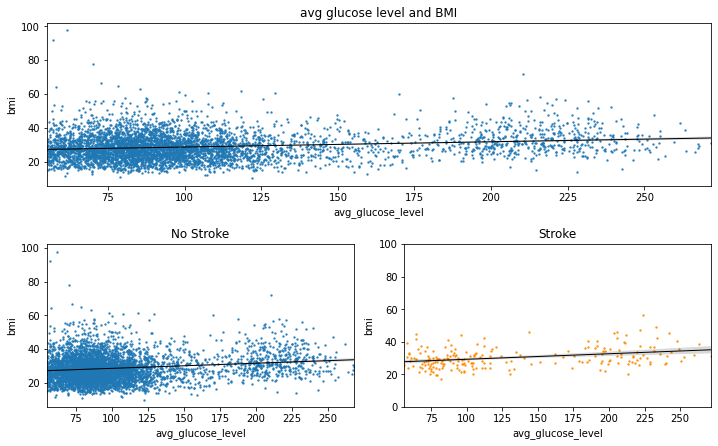

In [22]:
fig, ax = plt.subplots(figsize=(20,12))

ax = [None for _ in range(3)] # create # of axes

ax[0] = plt.subplot2grid((4,4), (0,0), colspan=2)
ax[1] = plt.subplot2grid((4,4), (1,0), colspan=1)
ax[2] = plt.subplot2grid((4,4), (1,1), colspan=1)
    
    
sns.regplot(x='avg_glucose_level', y='bmi', data=df, ax=ax[0], scatter_kws={'s':2}, line_kws={"color": "black", 'linewidth':1})
sns.regplot(x='avg_glucose_level', y='bmi', data=df[df['stroke'] == 0], ax=ax[1], scatter_kws={'s':2}, line_kws={"color": "black", 'linewidth':1})
sns.regplot(x='avg_glucose_level', y='bmi', color= '#FF8C00', data=df[df['stroke'] == 1], ax=ax[2], scatter_kws={'s':2}, line_kws={"color": "black", 'linewidth':1})

ax[0].set_title('avg glucose level and BMI')
ax[1].set_title('No Stroke')
ax[2].set_title('Stroke')

ax[2].set_ylim(0, 100)

plt.tight_layout()
plt.show()

Slight positive correlation from all graphs

# Smoking Status

In [23]:
df.groupby(['smoking_status'])['smoking_status'].describe()

,count,unique,top,freq
smoking_status,,,,
Unknown,1544,1,Unknown,1544
formerly smoked,884,1,formerly smoked,884
never smoked,1892,1,never smoked,1892
smokes,789,1,smokes,789


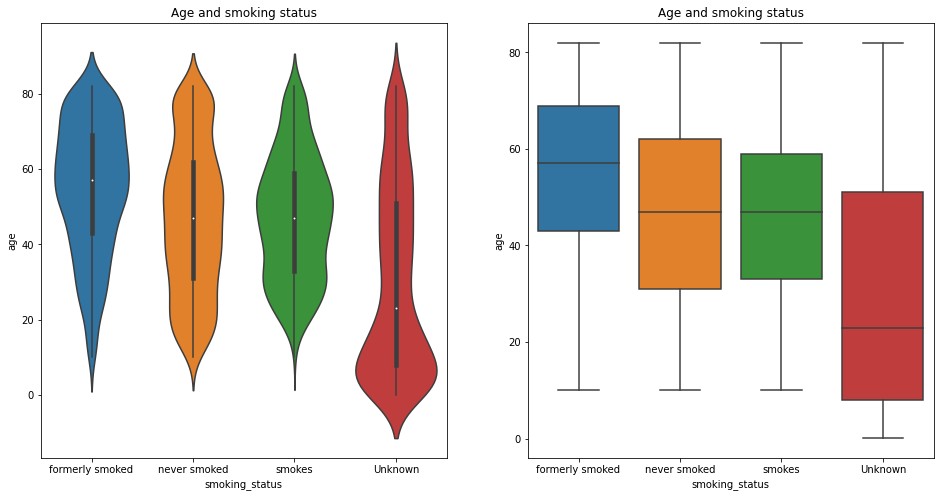

In [24]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

sns.violinplot(x='smoking_status', y='age', data=df, ax=ax[0])
sns.boxplot(x='smoking_status', y='age', data=df, ax=ax[1])

ax[0].set_title('Age and smoking status')
ax[1].set_title('Age and smoking status')

plt.show()

Seems that there is a lot of unknown values for ages below 20. Let's trying dividing up this group

In [25]:
# split the unknown smoking status into two groups: Unknown >20 age, and Unknown <20 age
df[(df['smoking_status'] == 'Unknown') & (df['age'] > 20)] = df[(df['smoking_status'] == 'Unknown') & (df['age'] > 20)].replace('Unknown','Unknown over 20')
df['smoking_status'] = df['smoking_status'].replace('Unknown', 'Unknown under 20')

In [26]:
pd.crosstab(df.smoking_status, df.stroke,
           rownames=['smoking_status'], colnames=['stroke'])

stroke,0,1
smoking_status,,
Unknown over 20,754,45
Unknown under 20,743,2
formerly smoked,814,70
never smoked,1802,90
smokes,747,42


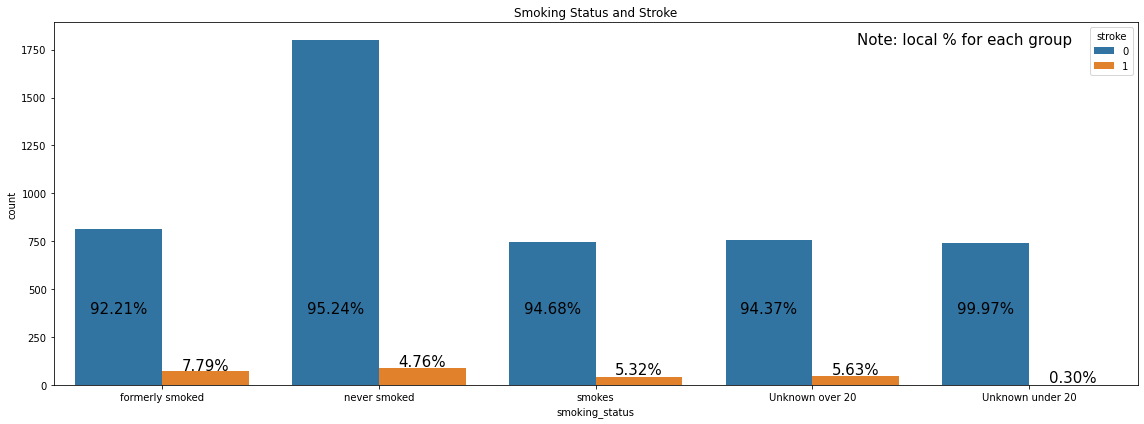

In [27]:
fig, ax = plt.subplots(figsize=(16,6))

sns.countplot(x='smoking_status', hue='stroke', data=df)

ax.text(-0.2, 400, "92.21%", va='center', ha='center', fontsize=15)
ax.text(0.2, 100, "7.79%", va='center', ha='center', fontsize=15)
ax.text(0.8, 400, "95.24%", va='center', ha='center', fontsize=15)
ax.text(1.2, 120, "4.76%", va='center', ha='center', fontsize=15)
ax.text(1.8, 400, "94.68%", va='center', ha='center', fontsize=15)
ax.text(2.2, 80, "5.32%", va='center', ha='center', fontsize=15)
ax.text(2.8, 400, "94.37%", va='center', ha='center', fontsize=15)
ax.text(3.2, 80, "5.63%", va='center', ha='center', fontsize=15)
ax.text(3.8, 400, "99.97%", va='center', ha='center', fontsize=15)
ax.text(4.2, 40, "0.30%", va='center', ha='center', fontsize=15)

ax.text(3.7, 1800, "Note: local % for each group", va='center', ha='center', fontsize=15)

plt.title('Smoking Status and Stroke')

plt.tight_layout()
plt.show()

Patients who formerly smoked or smokes had a slightly higher occurance of stroke than patients who never smoked.

# Preparing the Data

In [28]:
df.isnull().sum()
# will simple impute the bmi null values later on

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [29]:
# separate features and target
X = df.drop(['stroke'], axis=1)
y = df['stroke']

# split the data first before doing any

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Validation set

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

# separate numerical and categorical columns
X_num = X[['age', 'avg_glucose_level', 'bmi']]
X_cat = X[['gender', 'hypertension', 'heart_disease', 'ever_married', 
           'work_type', 'smoking_status', 'Residence_type']]

In [30]:
# pipeline

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
     ('scaler', StandardScaler())
])
    
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(sparse=False, drop='first'))
])

num_colnames = list(X_num)
cat_colnames = list(X_cat)


full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_colnames),
    ('cat', cat_pipeline, cat_colnames)
])

# SMOTE (resampling)
pipelinebsmote = Pipeline([
    ('smote', SMOTE(random_state=1))
])

# training set
X_train = full_pipeline.fit_transform(X_train)
X_train, y_train = pipelinebsmote.fit_resample(X_train, y_train)

# validation set
X_valid = full_pipeline.transform(X_valid)
X_valid, y_valid = pipelinebsmote.fit_resample(X_valid, y_valid)

# test set 
X_test = full_pipeline.transform(X_test)

# Make sure test set is not resampled 

# Modelling

In [31]:
# create an empty df with formatted index to be filled later on
iterables = [['LOG', 'KNN', 'SVC', 'RF', 'DT', 'GB'], ['ROC AUC', 'Precision', 'Recall', 'F1']]
iterabletuples = pd.MultiIndex.from_product(iterables, names=["Model", "Metric"])
results = pd.DataFrame(index = iterabletuples) 


def evalmodel(model, X, y):
    modelpred = model.predict(X)
    modelroc = roc_auc_score(y, modelpred)
    modelprec = precision_score(y, modelpred)
    modelrecall = recall_score(y, modelpred)
    modelf1 = f1_score(y, modelpred)
    ROC = round(modelroc, 3)
    prec = round(modelprec, 3)
    recall = round(modelrecall, 3)
    F1 = round(modelf1, 3)
    return ROC, prec, recall, F1

# models

logclf = LogisticRegression(random_state=1)
knnclf = KNeighborsClassifier()
svcclf = SVC(random_state=1)
rfclf = RandomForestClassifier(random_state=1)
dtclf = DecisionTreeClassifier(random_state=1)
gbclf = GradientBoostingClassifier(random_state=1)

listofmodels = [logclf, knnclf, svcclf, rfclf, dtclf, gbclf]
trainresults= [] # empty list to be converted to a column for results df

for i in listofmodels:
    i.fit(X_train, y_train)

for a in listofmodels:
    ROC, prec, recall, F1 = evalmodel(a, X_valid, y_valid)
    trainresults.extend([ROC, prec, recall, F1])

results['Training Set'] = trainresults
results

Training Set
Model Metric                 
LOG   ROC AUC           0.733
      Precision         0.731
      Recall            0.738
      F1                0.735
KNN   ROC AUC           0.631
      Precision         0.722
      Recall            0.427
      F1                0.536
SVC   ROC AUC           0.689
      Precision         0.763
      Recall            0.548
      F1                0.638
RF    ROC AUC           0.808
      Precision         0.957
      Recall            0.644
      F1                0.770
DT    ROC AUC           0.724
      Precision         0.842
      Recall            0.551
      F1                0.666
GB    ROC AUC           0.927
      Precision         0.934
      Recall            0.919
      F1                0.926

The GradientBoostingClassifier model seems to be doing the best with the validation data

# Randomized Search

In [32]:
# KNN
KNNparam = {
    'n_neighbors': range(3,15),
    'weights': ['uniform', 'distance'],
    'leaf_size': np.linspace(10,50,4)
    
}

KNNgrid = RandomizedSearchCV(KNeighborsClassifier(), KNNparam, cv=3, scoring='roc_auc')
KNNgrid.fit(X_train, y_train)


# SVC
SVCparam = {
    'C':[0.01, 0.1, 0.9, 1, 1.1, 10, 100],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': range(1,10)
    
}

SVCgrid = RandomizedSearchCV(SVC(random_state=1), SVCparam, cv=3, scoring='roc_auc')
SVCgrid.fit(X_train, y_train)


# LOG
LOGparam = {
    'C':[0.01, 0.1, 0.9, 1, 1.1, 10, 100],
    'class_weight':['dict', 'balanced']
}

LOGgrid = RandomizedSearchCV(LogisticRegression(random_state=1), LOGparam, cv=3, scoring='roc_auc')
LOGgrid.fit(X_train, y_train)



# RF
RFparam = {
    'max_depth': np.linspace(2,32,2),
    'n_estimators': range(100,1100,100),
    'min_samples_split': range(2,22,2)
}

RFgrid = RandomizedSearchCV(RandomForestClassifier(random_state=1), RFparam, cv=3, scoring='roc_auc')
RFgrid.fit(X_train, y_train)

# DT
DTparam = {
    'splitter': ['best','random'],
    'max_depth': np.linspace(2,32,2),
    'min_samples_split': range(2,22,2)
}

DTgrid = RandomizedSearchCV(DecisionTreeClassifier(random_state=1), DTparam, cv=3, scoring='roc_auc')
DTgrid.fit(X_train, y_train)

# GB
GBparam = {
    'max_depth': np.linspace(2,32,2),
    'n_estimators': range(100,1100,100),
    'learning_rate': [0.01,0.05,0.1,0.5, 1]
}

GBgrid = RandomizedSearchCV(GradientBoostingClassifier(random_state=1), GBparam, cv=3, scoring='roc_auc')
GBgrid.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=1),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.5,
                                                          1],
                                        'max_depth': array([ 2., 32.]),
                                        'n_estimators': range(100, 1100, 100)},
                   scoring='roc_auc')

In [33]:
listofgridmodels = [LOGgrid.best_estimator_, KNNgrid.best_estimator_, SVCgrid.best_estimator_, 
                RFgrid.best_estimator_, DTgrid.best_estimator_, GBgrid.best_estimator_]

gridresults = [] # empty list to be converted to a column for results df

for a in listofgridmodels:
    ROC, prec, recall, F1 = evalmodel(a, X_valid, y_valid)
    gridresults.extend([ROC, prec, recall, F1])

results['Grid Set'] = gridresults
results

Training Set  Grid Set
Model Metric                           
LOG   ROC AUC           0.733     0.733
      Precision         0.731     0.731
      Recall            0.738     0.738
      F1                0.735     0.735
KNN   ROC AUC           0.631     0.648
      Precision         0.722     0.717
      Recall            0.427     0.489
      F1                0.536     0.582
SVC   ROC AUC           0.689     0.688
      Precision         0.763     0.765
      Recall            0.548     0.542
      F1                0.638     0.634
RF    ROC AUC           0.808     0.811
      Precision         0.957     0.958
      Recall            0.644     0.650
      F1                0.770     0.775
DT    ROC AUC           0.724     0.746
      Precision         0.842     0.836
      Recall            0.551     0.612
      F1                0.666     0.707
GB    ROC AUC           0.927     0.955
      Precision         0.934     0.976
      Recall            0.919     0.934
      F1                0.926     0.954

# Evaluate model on Test Set

In [34]:
listofgridmodels = [LOGgrid.best_estimator_, KNNgrid.best_estimator_, SVCgrid.best_estimator_, 
                RFgrid.best_estimator_, DTgrid.best_estimator_, GBgrid.best_estimator_]

testresults = [] # empty list to be converted to a column for results df

for a in listofgridmodels:
    ROC, prec, recall, F1 = evalmodel(a, X_test, y_test)
    testresults.extend([ROC, prec, recall, F1])

results['Test Set'] = testresults
results

Training Set  Grid Set  Test Set
Model Metric                                     
LOG   ROC AUC           0.733     0.733     0.757
      Precision         0.731     0.731     0.146
      Recall            0.738     0.738     0.771
      F1                0.735     0.735     0.246
KNN   ROC AUC           0.631     0.648     0.642
      Precision         0.722     0.717     0.126
      Recall            0.427     0.489     0.470
      F1                0.536     0.582     0.199
SVC   ROC AUC           0.689     0.688     0.621
      Precision         0.763     0.765     0.128
      Recall            0.548     0.542     0.398
      F1                0.638     0.634     0.194
RF    ROC AUC           0.808     0.811     0.524
      Precision         0.957     0.958     0.150
      Recall            0.644     0.650     0.072
      F1                0.770     0.775     0.098
DT    ROC AUC           0.724     0.746     0.593
      Precision         0.842     0.836     0.137
      Recall            0.551     0.612     0.289
      F1                0.666     0.707     0.186
GB    ROC AUC           0.927     0.955     0.546
      Precision         0.934     0.976     0.200
      Recall            0.919     0.934     0.120
      F1                0.926     0.954     0.150

looks like LogisticRegression generalized the best since it has the best ROC AUC score.

- Note all models seem to overfit the training data and not generalize well with the test data. However, the training set has been resampled with SMOTE while the test data has not. As a result, the models are predicting on data that is severely imbalanced (few cases of patients with stroke)
- Interestingly enough for the LogisticRegression and the KNN model, the precision has definitely decreased with the test set, but the recall scores stayed consistent.

### Precision/Recall Plots for Logistic Regression

In [35]:
y_predict_proba = LOGgrid.best_estimator_.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_predict_proba)
recall = recall[:-1]
precision = precision[:-1]
# :-1 slice because threshold does not exist for last value in array for precision and recall

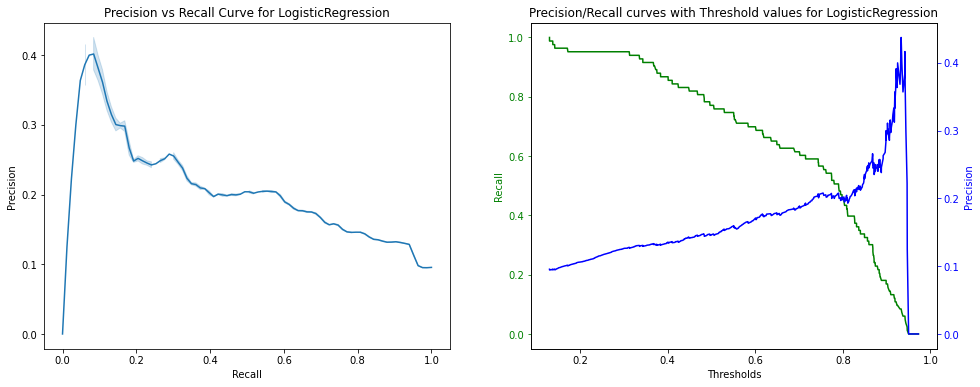

In [36]:
# Plot precision/recall curve with and w/o threshold values
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

sns.lineplot(recall, precision, ax=ax1) # w/o threshold values

sns.lineplot(x=thresholds, y=recall, color="g", ax=ax2) # with threshold values

ax12 = plt.twinx()
sns.lineplot(x=thresholds, y=precision, color="b", ax=ax12) 
# axis labels
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax12.set_ylabel('Precision')
ax2.set_ylabel('Recall')
ax2.set_xlabel('Thresholds')

ax2.yaxis.label.set_color('g')
ax2.tick_params(axis='y', colors='g')

ax12.yaxis.label.set_color('b')
ax12.tick_params(axis='y', colors='b')

ax1.set_title('Precision vs Recall Curve for LogisticRegression')
ax2.set_title('Precision/Recall curves with Threshold values for LogisticRegression')
# show the plot
plt.show()

Again with the imbalanced class issue, we see irregular shaped curves from both plots and so it's difficult to determine the best threshold value depending on if you want higher precision or recall score while optimally balancing between the two.